In [ ]:
######################### A note to the reviewer #########################
# Dear reviewer, thank you in advance for your time and effort in reviewing this project.
# This notebook contains all the code for the AI-driven agentic RAG system.
# Because the task involves showcasing multi-step reasoning and agentic flow, I have decided to use
# public information from a university as the data source, namely: Schedules and Course Catalog.
# The data have been legally scraped, with the full consent of the university (the scraper can be showcased separately, if needs be).
# Both of these data sources will be embedded, but into separate tablespaces / vector stores.
# The main idea behind this setup is to demonstrate a scenario where a person asks a question like
# 'How can I contact the professor of Natural Language Processing?', and and the agent's task here is
# to invoke the Schedules node first to find the teacher of the courese, and then invoke the Course Catalog node
# to find the person's contacts before generating the final response.
# Any other low-level details are going to be explained on the go, in the comments below. Thank you!

In [49]:
import os
from langchain.docstore.document import Document
import streamlit as st
import json
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_voyageai import VoyageAIEmbeddings
from typing_extensions import TypedDict
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.schema import HumanMessage
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, HumanMessage, SystemMessage
from langchain_chroma import Chroma
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import datetime

In [ ]:
os.environ["VOYAGE_API_KEY"] = ""

os.environ['OPENAI_API_KEY'] = ""

llm = ChatOpenAI(streaming=True, model_name="gpt-4o", temperature=0.4)

embeddings = VoyageAIEmbeddings(model="voyage-3-large", output_dimension=2048)

## Vectorstore Preparation

In [ ]:
def fill_list(dataset):

    docs1 = []

    for i in range(len(dataset)): 
        
        object = dict(dataset.iloc[i])
        
        unified = object['ticker'] + " " + object['description']

        doc = Document(page_content=unified, metadata={"ticker_name": object['ticker']})

        docs1.append(doc)

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=300)

    docs2 = text_splitter.split_documents(docs1)

    return docs2

ticker_docs = fill_list(ticker_info)

currency_history_store.add_documents(ticker_docs)

In [4]:
currency_history_store = Chroma(
    collection_name="currency_history_store",
    embedding_function=embeddings,
    persist_directory="/home/misha/Desktop/Spotware/data/chroma_data/"
)

## Bot Creation

In [55]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    sys_msg: str
    retry_attempt: int

In [88]:

@tool
def general_stock_data(user_question):
    """This tool retrieves general information about a currency, its history, its origins, etc."""
    retriever_general = currency_history_store.as_retriever(search_kwargs={"k": 3})

    template = ChatPromptTemplate.from_template("""This is a node within a RAG system for financial data.
    You will get information about a certain currency, and your task is to answer the user's question
    based on the retrieved context. Your answer should be detailed and profuse.
    Context: {context}
    Question: {question}""")

    chain = {"context": retriever_general, "question": RunnablePassthrough()} | template | llm | StrOutputParser()
    
    response_acquired = chain.invoke(str(user_question))

    return {"response": str(response_acquired)}


@tool
def output_currency_graph(user_question):
    """This function is designed to output visualizations for currency pairs. If the user asks to visualize a currency pair, but doesn't specify the number of days, ask them how many days they want. This tool outputs only the path to the generated plot, so when you're done, give the user the path"""

    ticker_prompt = ChatPromptTemplate.from_template("""You are going to get a user question that will contain some data about currency exchange.
                                                     Your task is to output two tickers separated by a semicolon, e.g. 'USD;EUR'. after the pair, also separated
                                                     by a semi-colon, you need to write either 'fiat' or 'crypto' (the former - if there isn't a crypto ticker
                                                     in the pair, the latter - if the pair involves any cryptocurrency). Write in the exact same way.
                                                     As the final and fourth entry, you need to write the number of days for which to show the data, e.g. '3d' for 3 days or '30d' for 30 days.
                                                     If the user doesn't specifcy the number of days, use '30d' as default. It must also be separated by a semicolon from the previous entries.
                                                     Don't output anything
                                                     else, do not provide any verbose or narration.
                                                     The user question is: {us_quest}""")
    
    ticker_chain = ticker_prompt | llm | StrOutputParser()
    
    tickers_received = ticker_chain.invoke(user_question)

    tickers_separated = tickers_received.split(";")

    print(tickers_separated)

    if tickers_separated[2] == 'fiat':

        forex_data = yf.Ticker(tickers_separated[0] + tickers_separated[1] + "=X")

        final_data = (forex_data.history(period=tickers_separated[3]))

    else:

        try:

            crypto_data = yf.Ticker(tickers_separated[0] + "-" + tickers_separated[1])

            final_data = (crypto_data.history(period=tickers_separated[3]))

            final_data.iloc[0]

        except:

            crypto_data = yf.Ticker(tickers_separated[1] + "-" + tickers_separated[0])

            final_data = (crypto_data.history(period=tickers_separated[3]))

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(final_data.index, final_data['Close'], marker='o', linestyle='-')

    ax.set_title('Close Prices Over Time')

    ax.set_xlabel('Date')

    ax.set_ylabel('Close Price')

    ax.grid(True)

    plt.xticks(rotation=45)

    plt.tight_layout()
    
    save_directory = "./frontend/saved_figures" 
    
    os.makedirs(save_directory, exist_ok=True)
        
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    filename = f"currency_chart_{tickers_separated[0]}_{tickers_separated[1]}_{timestamp}.png"

    filepath = os.path.join(save_directory, filename)


    fig.savefig(filepath, format="png", dpi=300, bbox_inches='tight')

    plt.close(fig)
        
    return {
            "response": "Your graph has been saved to: " + filepath,
            "filepath": filepath,
            "description": f"{tickers_separated[0]} to {tickers_separated[1]} currency chart"
        }



@tool
def get_stock_data(user_question):
    """This function is designed to get stock data from Yahoo Finance API. It returns the stock data for the given ticker(s). After receiving the data, ask the user if they want to visualize it and for how many days."""

    ticker_prompt = ChatPromptTemplate.from_template("""You are going to get a user question that will contain some data about currency exchange.
                                                     Your task is to output two tickers separated by a semicolon, e.g. 'USD;EUR'. after the pair, also separated
                                                     by a semi-colon, you need to write either 'fiat' or 'crypto' (the former - if there isn't a crypto ticker
                                                     in the pair, the latter - if the pair involves any cryptocurrency). Write in the exact same way.
                                                     Don't output anything
                                                     else, do not provide any verbose or narration.
                                                     The user question is: {us_quest}""")
    
    ticker_chain = ticker_prompt | llm | StrOutputParser()
    
    tickers_received = ticker_chain.invoke(user_question)

    tickers_separated = tickers_received.split(";")

    print(tickers_separated)

    if tickers_separated[2] == 'fiat':

        forex_data = yf.Ticker(tickers_separated[0] + tickers_separated[1] + "=X")

        final_data = (forex_data.history(period="3d")).to_dict()

    else:

        try:

            crypto_data = yf.Ticker(tickers_separated[0] + "-" + tickers_separated[1])

            final_data = (crypto_data.history(period="3d")).to_dict()

            final_data.iloc[0]

        except:

            crypto_data = yf.Ticker(tickers_separated[1] + "-" + tickers_separated[0])

            final_data = (crypto_data.history(period="3d")).to_dict()

    ticker_prompt2 = ChatPromptTemplate.from_template("""You are going to get a user question and some stock information retrieved from financial APIs. Generate
                                                      a concise response based on the information provided. Provide both ratios, currency1 to currency2 and currency 2
                                                      to currency1. Answer based on the Close values
                                                      The user question is: {us_quest}
                                                      The latest stock exchange data is: {stock_info}""")
    
    ticker_chain2 = ticker_prompt2 | llm | StrOutputParser()

    rag_response = ticker_chain2.invoke({"us_quest": user_question, "stock_info": str({"Close values":final_data['Close'], "Open values":final_data['Open']})})

    return {"response": str(rag_response)}



def toxicity_guardrail(state: State):
    """Checks the toxicity of a user question and decides whether to proceed or to stop"""
    llm = ChatOpenAI(streaming=True, model_name="gpt-4o-mini-2024-07-18", temperature=0.4)
    user_question = state["messages"][-1]
    toxicity_check_prompt = ChatPromptTemplate.from_template("""You are going to get a user question that needs to be checked for relevance and toxicity.
                    There will be 2 parameters to check, and each needs to be assigned a score from 1 to 5. 
                    - Toxicity, harassment, hate speech, extremist materials, political questions (5 means 'not toxic or dangerous at all', 1 means 'highly toxic, contains hate speech')
                    - Pop-culture references (5 means 'no references', 1 means 'a lot of references that make the question irrelevant to the university').
                    Output only these scores, no verbose or narration, separate them by a semicolon, e.g. 1;4. There may be some intermediary in-context messages like 'Yes', 
                    'No', 'Sure', 'What about' - they have to be considered part of the conversation and SHOULD NOT be assigned low scores.
                    The user question is: {user_question}""")
    toxicity_check_chain = toxicity_check_prompt | llm | StrOutputParser()
    toxicity_results = toxicity_check_chain.invoke(user_question)
    toxicity_scores = toxicity_results.split(";")
    output = [int(x) for x in toxicity_scores]
    if any(x < 4 for x in output):
        return "0"
    else:
        return "1"
    
def refuse(state: State):
    """If the toxicity guardrail is triggered, refuse to answer"""
    return {"messages": ["I'm sorry, but I cannot assist with that. If you have any other university-related questions, feel free to ask!"]}


def intermediate_node(state: State):
    """This node is for intermediate messages before the triage check"""
    
    return {"graph_response": state['messages'][-1]}

def response_triage(state: State):
    """Checks whether the final answer contains the information the user asked about"""

    llm = ChatOpenAI(streaming=True, model_name="gpt-4o", temperature=0.4)

    graph_response = state["messages"][-1]
    
    relevance_prompt = ChatPromptTemplate.from_template("""You are going to get a response from a RAG System. 
                    - If the response 
                    informs the user that the information has not been found, return 0. 
                    - If the response contains certain information and does not 
                    involve an apology or a denial of the user's request, return 1.
                    Sometimes the response may be intermediary (a part of the conversation, 
                    not a response to a question), in which case return 1.
                    Return only the number and nothing else, no verbose, no narration.

                    The graph response is: {graph_response}""")
    
    relevance_check_chain = relevance_prompt | llm | StrOutputParser()
    
    relevance_results = relevance_check_chain.invoke(graph_response)
    
    output = int(relevance_results)

    current_retry = state["retry_attempt"]

    print("Triage check says: " + str(output))

    if output != 1 and current_retry <= 2:
        return "0"
    
    else:
        return "1"

def reformulate_us_query(state: State):
    """If the response_triage node deems the final response irrelevant"""

    current_retry = state["retry_attempt"]

    new_retry_count = current_retry + 1

    if new_retry_count > 2:
        return {
            "messages": [HumanMessage(content="I apologize, but I'm having trouble finding the information you're looking for after multiple attempts.")],
            "retry_attempt": new_retry_count
        }

    print("Current retry count: " + str(current_retry))

    print("New retry count: " + str(new_retry_count))

    try:
        for msg in reversed(state['messages']):

            if isinstance(msg, AIMessage) and hasattr(msg, "tool_calls"):
            
                    tool_calls = msg.tool_calls
            
                    if tool_calls:
            
                        user_query = tool_calls[0]["args"]["user_question"]
    except:
    
        user_query = "There are no user questions."

    reform_prompt = ChatPromptTemplate.from_template("""You are going to get a user question that needs to be reformulated for the purposes of similarity search.
                                                     Saturate it with keywords and other relevant information that will help the system find the right answer.
                                                     The user question is: {user_query}""")
    reform_chain = reform_prompt | llm | StrOutputParser()

    reformulated_query = reform_chain.invoke(user_query)
    
    return {
        "messages": [HumanMessage(content=reformulated_query)], "retry_attempt": new_retry_count,
    }

graph_builder = StateGraph(State)

tools = [general_stock_data, get_stock_data, output_currency_graph]

multiple_tools = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(content="""You are a RAG chatbot for financial analysis at Spotware.

IMPORTANT: Before calling any tools, you MUST ALWAYS explain your reasoning:
1. Analyze the user's question
2. Determine which tool(s) are most appropriate and why
3. Explain your decision-making process
4. Then call the appropriate tool(s)
You **MUST ALWAYS* Enclose your reasoning section in /// at the beginning and /// at the end.
                        
You are **not allowed** to answer the question by yourself.
Always delegate questions about currency origins, history, or context (or dates) to the `general_stock_data` tool.

Available tools:
- general_stock_data: For questions regarding general information about a currency, its history, origins, etc.;
- get_stock_data: specific data for Open / Close values between a pair of currencies / cryptocurrencies;
- output_currency_graph: for visualizing the data of a currency pair, saving the plot.
                        
If the question is about the history of currencies, don't try to answer it yourself, fetch the necessary data from the tools. If the user
                        message is cryptic and doesn't specify the currency, do not try to define it yourself, use the tool for it.
You may use multiple tools per query to ensure comprehensive answers. If one tool doesn't provide sufficient information, try another.""")


In [89]:
def chatbot(state: State):
    messages = state["messages"]
    if sys_msg not in messages:  
        messages = [sys_msg] + messages
        
    return {"messages": [llm_with_tools.invoke(messages)]}


graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("refuse_to_cooperate", refuse)

graph_builder.add_node("before_output", intermediate_node)

graph_builder.add_node("reformulate", reformulate_us_query)

graph_builder.add_node("tools", multiple_tools)

graph_builder.add_edge("tools", "chatbot")

# Cooperation / disagreement

graph_builder.add_conditional_edges(
    START,
    toxicity_guardrail,
    {
        "0": "refuse_to_cooperate",
        "1": "chatbot"
    }
)

graph_builder.add_edge("refuse_to_cooperate", END)

# Triage and tool calling

def tools_condition(state: State):
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    return "before_output"

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "tools",
        "before_output": "before_output"
    }
)

graph_builder.add_conditional_edges(
    "before_output", 
    response_triage,
    {
        "0": "reformulate",
        "1": END
    }
)

graph_builder.add_edge("reformulate", "chatbot")

memory = MemorySaver()

config = {"configurable": {"thread_id": "1"}}

### Memory useless while using StreamLit.
graph = graph_builder.compile(checkpointer=memory)

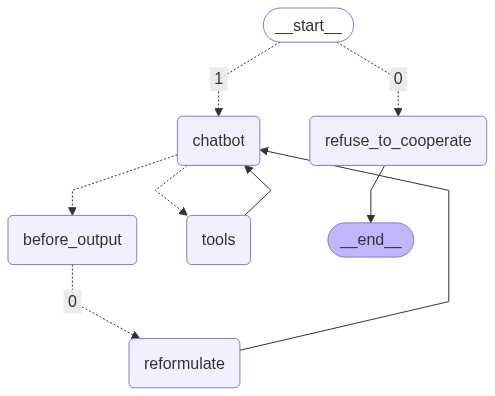

In [90]:
## Visualize the graph

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
# Possible questions:
# What is the exchange rate between two currencies - one intorduced by a Federal Coinage Act in 1850 and the other pegged to pound in 1949?" (multitool - general_stock_data + get_stock_data)
# What is the exchange rate between two currencies - one intorduced by a Federal Coinage Act in 1850 and Ruble? (multitool - general_stock_data + get_stock_data)
# Visualize the relationship between two currencies for the last 50 days. one currency was issued in 1950 and later redenominated by dropping four zeros to save the economy and the other, the name of which was derived from the Sanskrit word for 'silver' (multitool - general_stock_data + get_stock_data)
# What is the exchange rate between USD and BTC? (one tool - get_stock_data)
# Visualize the exchange rate between RUB and BTC over the last 50 days. (one tool - output_currency_graph)

# For memory demo:
# Tell me the history of Singapore Dollar (one tool - general_stock_data) ---> What is its exchange rate to USD? (one tool - get_stock_data)

user_input = "What is the exchange rate between two currencies - one intorduced by a Federal Coinage Act in 1850 and the other pegged to pound in 1949?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}], 'retry_attempt': 0},
    config,
    stream_mode="values",
)
res = []

for event in events:
    res.append(event["messages"][-1].content)
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the exchange rate between two currencies - one intorduced by a Federal Coinage Act in 1850 and the other pegged to pound in 1949?
================================== Ai Message ==================================

/// 
To determine the exchange rate between the two currencies mentioned, we first need to identify them based on the historical context provided:

1. **Currency introduced by a Federal Coinage Act in 1850:** This likely refers to the Swiss Franc, which was established by the Federal Coinage Act in Switzerland in 1850.

2. **Currency pegged to the pound in 1949:** This could refer to the Hong Kong Dollar, which was pegged to the British Pound in 1949.

Once we have identified these currencies, we can look up the current exchange rate between the Swiss Franc (CHF) and the Hong Kong Dollar (HKD).

I will use the `general_stock_data` tool to confirm the historical context of these currencies 

In [98]:
res[1].split("///")[1]

' \nTo determine the exchange rate between the two currencies mentioned, we first need to identify them based on the historical context provided:\n\n1. **Currency introduced by a Federal Coinage Act in 1850:** This likely refers to the Swiss Franc, which was established by the Federal Coinage Act in Switzerland in 1850.\n\n2. **Currency pegged to the pound in 1949:** This could refer to the Hong Kong Dollar, which was pegged to the British Pound in 1949.\n\nOnce we have identified these currencies, we can look up the current exchange rate between the Swiss Franc (CHF) and the Hong Kong Dollar (HKD).\n\nI will use the `general_stock_data` tool to confirm the historical context of these currencies and then use the `get_stock_data` tool to find the current exchange rate. \n'